In [1]:
#import getpass
import os
from dotenv import load_dotenv

#def _set_env(var: str):
#    if not os.environ.get(var):
#        os.environ[var] = getpass.getpass(f"{var}: ")

load_dotenv()
#_set_env("OPENAI_API_KEY")
#_set_env("TAVILY_API_KEY")

True

In [2]:
#%%capture --no-stderr
#!pip install -U langgraph langchain-community langchain-openai tavily-python pandas
#!pip install -qU langchain-text-splitters

## Tools

In [3]:
import openai
import requests
from langchain_core.tools import tool
from datetime import date, datetime
from typing import Optional, Union
from langchain_text_splitters import RecursiveJsonSplitter
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from uuid import uuid4
from langchain_core.documents import Document
import faiss
import json
import concurrent.futures
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import Runnable, RunnableConfig
from typing import Callable
from langchain_core.messages import ToolMessage

/home/cristobal/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


### Hotels

In [4]:
@tool
def get_availability_for_hotels(
    townId: Optional[str] = None,
    checkin_date: Optional[str] = None,
    checkout_date: Optional[str] = None,
    adults: Optional[int] = 1,
    children: Optional[int] = 0,
    infants: Optional[int] = 0,
    ages: Optional[list[int]] = [],
    currency: Optional[int] = 1,
) -> list[dict]:
    """
    Get availability of hotels in a given town.

    Args:
    townId: The town ID.
    checkin_date (string): The check-in date.
    checkout_date (string): The check-out date.
    adults: The number of adults. Default is 1.
    children: The number of children. Default is 0.
    infants: The number of infants. Default is 0.
    ages: The ages of the children. Default is [].
    currency: The currency. Default is 1.

    Returns:
    A list of dictionaries containing the availability of
    hotels in the given town.

    Example:
    get_availability(townId='1234', checkin_date='2022-12-01', checkout_date='2022-12-05', adults=2, children=1)    
    """
    url = f'{os.getenv("CTS_API_V2")}/hotel/'

    ctsToken = os.getenv("CTS_TOKEN")
    headers = {'Authorization': f'token {ctsToken}'}
    json = {'townId': townId, 'checkin': checkin_date, 'checkout': checkout_date, 'rooms': [{'adults': adults, 'children': children, 'infants': infants, 'ages': ages}], 'currency': currency}
    response = requests.post(url, json=json, headers=headers)
    result = generate_hotels_availability_response(response.json())
    return result

@tool
def get_town_id_for_hotels(townName: str) -> list[dict]:
    """
    Get the town ID.

    Args:
    townName: The town or city name.

    Returns:
    The Town ID.

    Example:
    get_city_id('santiago')
    """
    url = f'{os.getenv("CTS_API_V2")}/city/dtt/?q={townName}'
    ctsToken = os.getenv("CTS_TOKEN")
    headers = {'Authorization': f'token {ctsToken}'}
    response = requests.get(url, headers=headers)
    return response.json()[0]['dtt_id']

#TODO
@tool
def create_hotel_booking()-> list[dict]:
    """
    Create a hotel booking.

    Returns:
    The booking ID.

    Example:
    create_hotel_booking()
    """
    url = f'{os.getenv("CTS_API_V2")}/booking/'
    ctsToken = os.getenv("CTS_TOKEN")
    headers = {'Authorization': f'token {ctsToken}'}
    response = requests.post(url, headers=headers)
    return response.json()

#TODO
@tool
def update_hotel_booking()-> list[dict]:
    """
    Update a hotel booking.

    Returns:
    The booking ID.

    Example:
    update_hotel_booking()
    """
    url = f'{os.getenv("CTS_API_V2")}/booking/'
    ctsToken = os.getenv("CTS_TOKEN")
    headers = {'Authorization': f'token {ctsToken}'}
    response = requests.put(url, headers=headers)
    return response.json()

#TODO
@tool
def cancel_hotel_booking(bookingId: str)-> list[dict]:
    """
    Cancel a hotel booking.

    Args:
    bookingId: The booking ID.

    Returns:
    The booking ID.

    Example:
    cancel_hotel_booking('1234')
    """
    url = f'{os.getenv("CTS_API_V2")}/booking/{bookingId}/'
    ctsToken = os.getenv("CTS_TOKEN")
    headers = {'Authorization': f'token {ctsToken}'}
    response = requests.delete(url, headers=headers)
    return response.json()

### Excursions and transport

In [5]:
@tool
def get_availability_for_transfer_and_excursions(
    townId: Optional[int] = None,
    tipos: Optional[int] = None,
    fecha: Optional[str] = None,
    adults: Optional[int] = 1,
    children: Optional[int] = 0,
    currency: Optional[int] = 1,
    ) -> list[dict]:
    """
    Get availability of transport or excursions in a given town.

    Args:
    townId: The town ID.
    tipos: The type of service. 1 is for transfer, and 2 is for excursions.
    fecha (string): The date (format YYYY-MM-DD).
    adults: The number of adults. Default is 1.
    children: The number of children. Default is 0.
    currency: The currency. 1 is for CLP, and 2 is for USD. Default is 1.

    Returns:
    A list of dictionaries containing the availability of
    transport or excursions in the given town.

    Example:
    get_availability_for_transport_and_excursions(townId='1234', tipos='1', fecha='2024-12-01', adults=2, children=1, currency=1)
    """

    url = f'{os.getenv("CTS_API_V2")}/availability/?townId={townId}&tipos={tipos}&fecha={fecha}&adults={adults}&children={children}&currency={currency}'
    ctsToken = os.getenv("CTS_TOKEN")
    headers = {'Authorization': f'token {ctsToken}'}
    response = requests.get(url, headers=headers)
    #TODO
    if tipos == 1:
        result = generate_transfer_availability_response(response.json())
    if tipos == 2:
        result = generate_excursion_availability_response(response.json())
    return result

@tool
def get_town_id_for_transport_and_excursions(townName: str) -> list[dict]:
    """
    Get the town ID.

    Args:
    townName: The town or city name.

    Returns:
    The Town ID.

    Example:
    get_town_id_for_transport_and_excursions('santiago')
    """
    url = f'{os.getenv("CTS_API_V2")}/city/'
    ctsToken = os.getenv("CTS_TOKEN")
    headers = {'Authorization': f'token {ctsToken}'}
    response = requests.get(url, headers=headers)

    for town in response.json():
        if town['name'].lower() == townName.lower():
            return town['id']
        
    return None

#TODO
@tool
def create_transport_or_excursion_booking() -> list[dict]:
    """
    Create a transport or excursion booking.

    Returns:
    The booking ID.

    Example:
    create_transport_or_excursion_booking()
    """
    url = f'{os.getenv("CTS_API_V2")}/booking/'
    ctsToken = os.getenv("CTS_TOKEN")
    headers = {'Authorization': f'token {ctsToken}'}
    response = requests.post(url, headers=headers)
    return response.json()

#TODO
@tool
def update_transport_or_excursion_booking() -> list[dict]:
    """
    Update a transport or excursion booking.

    Returns:
    The booking ID.

    Example:
    update_transport_or_excursion_booking()
    """
    url = f'{os.getenv("CTS_API_V2")}/booking/'
    ctsToken = os.getenv("CTS_TOKEN")
    headers = {'Authorization': f'token {ctsToken}'}
    response = requests.put(url, headers=headers)
    return response.json()

#TODO
@tool
def cancel_transport_or_excursion_booking(bookingId: str) -> list[dict]:
    """
    Cancel a transport or excursion booking.

    Args:
    bookingId: The booking ID.
    
    Returns:
    The booking ID.
    
    Example:
    cancel_transport_or_excursion_booking('1234')
    """
    url = f'{os.getenv("CTS_API_V2")}/booking/{bookingId}/'
    ctsToken = os.getenv("CTS_TOKEN")
    headers = {'Authorization': f'token {ctsToken}'}
    response = requests.delete(url, headers=headers)
    return response.json()




# Controllers

def generate_hotels_availability_response(json_response):
    result = []
    hotel = {}
    for data in json_response['data']:
        hotel['hotelId'] = data['id']
        hotel['hotelName'] = data['name']
        hotel['stars'] = data['category']['rating']
        hotel['hotelAddress'] = data['address']
        priceList = map(lambda x: x['price_value_with_tax'], data['availability'])
        hotel['priceFrom'] = min(priceList)
        result.append(hotel)
    return result

#TODO
def generate_excursion_availability_response(json_response):
    result = []
    service = {}
    for data in json_response:
        service['serviceDescription'] = data['glosas']
        service['priceFrom'] = data['services'][0]['sale_price']
        service['duration'] = data['services'][0]['service_duration']
        service['allowChildren'] = data['services'][0]['allow_childs']
        result.append(service)
    return result
    

def generate_transfer_availability_response(json_response):
    result = []
    service = {}
    for data in json_response:
        service['serviceDescription'] = data['glosas']
        service['priceFrom'] = data['services'][0]['sale_price']
        service['pickup'] = data['services'][0]['meeting_point']
        service['allowChildren'] = data['services'][0]['allow_childs']
        result.append(service)
    return result

## Controllers

In [6]:
#town = get_town_id_for_transport_and_excursions('Providencia')
#print(town)

In [7]:
#hotels = get_availability_for_hotels(townId='51', checkin_date='2024-10-04', checkout_date='2024-10-05', adults=2, children=1, infants=0, ages=[5])
#print(hotels)

In [8]:
#transport_or_excursions = get_availability_for_transfer_and_excursions(townId=295, tipos=2, fecha='2024-10-10', adults=2, children=1, currency=1)
#print(transport_or_excursions)

## Utilities

In [9]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

## State

In [10]:
from typing import Annotated, Literal, Optional

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


def update_dialog_stack(left: list[str], right: Optional[str]) -> list[str]:
    """Push or pop the state."""
    if right is None:
        return left
    if right == "pop":
        return left[:-1]
    return left + [right]


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    #user_info: str
    dialog_state: Annotated[
        list[
            Literal[
                "assistant",
                "book_hotel",
                "book_excursion",
            ]
        ],
        update_dialog_stack,
    ]

## Assistants

In [11]:
# The top-level assistant performs general Q&A and delegates specialized tasks to other assistants.
# The task delegation is a simple form of semantic routing / does simple intent detection
# llm = ChatAnthropic(model="claude-3-haiku-20240307")
# llm = ChatAnthropic(model="claude-3-sonnet-20240229", temperature=1)
llm = ChatOpenAI(model="gpt-4-turbo", temperature=0)

In [12]:
class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)

            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


class CompleteOrEscalate(BaseModel):
    """A tool to mark the current task as completed and/or to escalate control of the dialog to the main assistant,
    who can re-route the dialog based on the user's needs."""

    cancel: bool = True
    reason: str

    class Config:
        schema_extra = {
            "example": {
                "cancel": True,
                "reason": "User changed their mind about the current task.",
            },
            "example 2": {
                "cancel": True,
                "reason": "I have fully completed the task.",
            },
            "example 3": {
                "cancel": False,
                "reason": "I need to search the user's emails or calendar for more information.",
            },
        }


# Hotel Booking Assistant
book_hotel_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling hotel bookings. "
            "The primary assistant delegates work to you whenever the user needs help booking a hotel. "
            "Search for available hotels based on the user's preferences and confirm the booking details with the customer. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\nCurrent time: {time}."
            '\n\nIf the user needs help, and none of your tools are appropriate for it, then "CompleteOrEscalate" the dialog to the host assistant.'
            " Do not waste the user's time. Do not make up invalid tools or functions."
            "\n\nSome examples for which you should CompleteOrEscalate:\n"
            " - 'what's the weather like this time of year?'\n"
            " - 'nevermind i think I'll book separately'\n"
            " - 'i need to figure out transportation while i'm there'\n"
            " - 'Oh wait i haven't booked my flight yet i'll do that first'\n"
            " - 'Hotel booking confirmed'",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

book_hotel_safe_tools = [get_availability_for_hotels, get_town_id_for_hotels]
book_hotel_sensitive_tools = [create_hotel_booking, update_hotel_booking, cancel_hotel_booking]
book_hotel_tools = book_hotel_safe_tools + book_hotel_sensitive_tools
book_hotel_runnable = book_hotel_prompt | llm.bind_tools(
    book_hotel_tools + [CompleteOrEscalate]
)

# Transfer and excursion Assistant

book_excursion_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling trip recommendations. "
            "The primary assistant delegates work to you whenever the user needs help booking a recommended trip. "
            "Search for available trip recommendations based on the user's preferences and confirm the booking details with the customer. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\nCurrent time: {time}."
            '\n\nIf the user needs help, and none of your tools are appropriate for it, then "CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.'
            "\n\nSome examples for which you should CompleteOrEscalate:\n"
            " - 'nevermind i think I'll book separately'\n"
            " - 'i need to figure out transportation while i'm there'\n"
            " - 'Oh wait i haven't booked my flight yet i'll do that first'\n"
            " - 'Excursion booking confirmed!'",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

book_excursion_safe_tools = [get_availability_for_transfer_and_excursions, get_town_id_for_transport_and_excursions]
book_excursion_sensitive_tools = [create_transport_or_excursion_booking, update_transport_or_excursion_booking, cancel_transport_or_excursion_booking]
book_excursion_tools = book_excursion_safe_tools + book_excursion_sensitive_tools
book_excursion_runnable = book_excursion_prompt | llm.bind_tools(
    book_excursion_tools + [CompleteOrEscalate]
)


# Primary Assistant
class ToHotelBookingAssistant(BaseModel):
    """Transfer work to a specialized assistant to handle hotel bookings."""

    location: str = Field(
        description="The location where the user wants to book a hotel."
    )
    checkin_date: str = Field(description="The check-in date for the hotel.")
    checkout_date: str = Field(description="The check-out date for the hotel.")
    request: str = Field(
        description="Any additional information or requests from the user regarding the hotel booking."
    )

    class Config:
        schema_extra = {
            "example": {
                "location": "Zurich",
                "checkin_date": "2023-08-15",
                "checkout_date": "2023-08-20",
                "request": "I prefer a hotel near the city center with a room that has a view.",
            }
        }


class ToBookExcursion(BaseModel):
    """Transfers work to a specialized assistant to handle trip recommendation and other excursion bookings."""

    location: str = Field(
        description="The location where the user wants to book a recommended trip."
    )
    request: str = Field(
        description="Any additional information or requests from the user regarding the trip recommendation."
    )

    class Config:
        schema_extra = {
            "example": {
                "location": "Lucerne",
                "request": "The user is interested in outdoor activities and scenic views.",
            }
        }


primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Your name is CTS Travel Assistant."
            "You are a customer service assistant for CTS Turismo (Chilean Travel Services). "
            "CTS Turismo is a tourism company that offers varied tourism services in Chile. "
            "The services they offer are the following: hotels, excursions, transfers and tour packages. "
            "Hotels: Hotel reservations throughout Chile. "
            "Excursions: Tours and activities in different cities and locations in Chile. "
            "Transfers: Transportation from one point to another, such as to and from the airport or the bus terminal, or to and from the snow or the beach, etc. "
            "Tour packages: Combination of hotels, excursions and transfers at a single price. "
            "Your goal is to help users find the services described above and all other relevant information. "
            "By default, you must give your answers in Spanish. However, if the user writes to you in a different language, your answers should be in that language. "
            "Use the tools provided to search for hotels, excursions, transfers and packages and other information that will help in the user's queries. "
            "If a customer requests to create, update or cancel a hotel, transfer or excursion reservation; or, when searching for a hotel, excursion or transfer, needs specialized recommendations, "
            "delegate the task to the appropriate specialized assistant by invoking the corresponding tool. You are not able to make these types of changes yourself. "
            "The user is not aware of the different specialized assistants, so do not mention them; just quietly delegate through function calls. "
            "Provide detailed information to the customer, and always double-check the database before concluding that information is unavailable. "
            "When searching, be persistent. Expand your query bounds if the first search returns no results. "
            "If a search comes up empty, expand your search before giving up."
            #"\n\nCurrent user flight information:\n<Flights>\n{user_info}\n</Flights>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

primary_assistant_tools = [
    TavilySearchResults(max_results=1)
]
assistant_runnable = primary_assistant_prompt | llm.bind_tools(
    primary_assistant_tools
    + [
        ToHotelBookingAssistant,
        ToBookExcursion,
    ]
)

## Utility

In [13]:

def create_entry_node(assistant_name: str, new_dialog_state: str) -> Callable:
    def entry_node(state: State) -> dict:
        tool_call_id = state["messages"][-1].tool_calls[0]["id"]
        return {
            "messages": [
                ToolMessage(
                    content=f"The assistant is now the {assistant_name}. Reflect on the above conversation between the host assistant and the user."
                    f" The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are {assistant_name},"
                    " and the booking, update, other other action is not complete until after you have successfully invoked the appropriate tool."
                    " If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control."
                    " Do not mention who you are - just act as the proxy for the assistant.",
                    tool_call_id=tool_call_id,
                )
            ],
            "dialog_state": new_dialog_state,
        }

    return entry_node

## Graph

In [14]:
from typing import Literal

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


# def user_info(state: State):
#     return {"user_info": fetch_user_flight_information.invoke({})}


# builder.add_node("fetch_user_info", user_info)
# builder.add_edge(START, "fetch_user_info")
#builder.add_node("primary_assistant", Assistant(assistant_runnable))
#builder.add_edge(START, "primary_assistant")
# Primary assistant
builder.add_node("primary_assistant", Assistant(assistant_runnable))
builder.add_node(
    "primary_assistant_tools", create_tool_node_with_fallback(primary_assistant_tools)
)
builder.add_edge(START, "primary_assistant")

In [15]:
# This node will be shared for exiting all specialized assistants
def pop_dialog_state(state: State) -> dict:
    """Pop the dialog stack and return to the main assistant.

    This lets the full graph explicitly track the dialog flow and delegate control
    to specific sub-graphs.
    """
    messages = []
    if state["messages"][-1].tool_calls:
        # Note: Doesn't currently handle the edge case where the llm performs parallel tool calls
        messages.append(
            ToolMessage(
                content="Resuming dialog with the host assistant. Please reflect on the past conversation and assist the user as needed.",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        )
    return {
        "dialog_state": "pop",
        "messages": messages,
    }


builder.add_node("leave_skill", pop_dialog_state)
builder.add_edge("leave_skill", "primary_assistant")

In [16]:
# Hotel booking assistant
builder.add_node(
    "enter_book_hotel", create_entry_node("Hotel Booking Assistant", "book_hotel")
)
builder.add_node("book_hotel", Assistant(book_hotel_runnable))
builder.add_edge("enter_book_hotel", "book_hotel")
builder.add_node(
    "book_hotel_safe_tools",
    create_tool_node_with_fallback(book_hotel_safe_tools),
)
builder.add_node(
    "book_hotel_sensitive_tools",
    create_tool_node_with_fallback(book_hotel_sensitive_tools),
)


def route_book_hotel(
    state: State,
) -> Literal[
    "leave_skill", "book_hotel_safe_tools", "book_hotel_sensitive_tools", "__end__"
]:
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    tool_names = [t.name for t in book_hotel_safe_tools]
    if all(tc["name"] in tool_names for tc in tool_calls):
        return "book_hotel_safe_tools"
    return "book_hotel_sensitive_tools"


builder.add_edge("book_hotel_sensitive_tools", "book_hotel")
builder.add_edge("book_hotel_safe_tools", "book_hotel")
builder.add_conditional_edges("book_hotel", route_book_hotel)

In [17]:
# Excursion assistant
builder.add_node(
    "enter_book_excursion",
    create_entry_node("Trip Recommendation Assistant", "book_excursion"),
)
builder.add_node("book_excursion", Assistant(book_excursion_runnable))
builder.add_edge("enter_book_excursion", "book_excursion")
builder.add_node(
    "book_excursion_safe_tools",
    create_tool_node_with_fallback(book_excursion_safe_tools),
)
builder.add_node(
    "book_excursion_sensitive_tools",
    create_tool_node_with_fallback(book_excursion_sensitive_tools),
)


def route_book_excursion(
    state: State,
) -> Literal[
    "book_excursion_safe_tools",
    "book_excursion_sensitive_tools",
    "leave_skill",
    "__end__",
]:
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    tool_names = [t.name for t in book_excursion_safe_tools]
    if all(tc["name"] in tool_names for tc in tool_calls):
        return "book_excursion_safe_tools"
    return "book_excursion_sensitive_tools"


builder.add_edge("book_excursion_sensitive_tools", "book_excursion")
builder.add_edge("book_excursion_safe_tools", "book_excursion")
builder.add_conditional_edges("book_excursion", route_book_excursion)

In [18]:
def route_primary_assistant(
    state: State,
) -> Literal[
    "primary_assistant_tools",
    "enter_book_hotel",
    "enter_book_excursion",
    "__end__",
]:
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if tool_calls[0]["name"] == ToHotelBookingAssistant.__name__:
            return "enter_book_hotel"
        elif tool_calls[0]["name"] == ToBookExcursion.__name__:
            return "enter_book_excursion"
        return "primary_assistant_tools"
    raise ValueError("Invalid route")


# The assistant can route to one of the delegated assistants,
# directly use a tool, or directly respond to the user
builder.add_conditional_edges(
    "primary_assistant",
    route_primary_assistant,
    {
        "enter_book_hotel": "enter_book_hotel",
        "enter_book_excursion": "enter_book_excursion",
        "primary_assistant_tools": "primary_assistant_tools",
        END: END,
    },
)
builder.add_edge("primary_assistant_tools", "primary_assistant")


# Each delegated workflow can directly respond to the user
# When the user responds, we want to return to the currently active workflow
def route_to_workflow(
    state: State,
) -> Literal[
    "primary_assistant",
    "book_hotel",
    "book_excursion",
]:
    """If we are in a delegated state, route directly to the appropriate assistant."""
    dialog_state = state.get("dialog_state")
    if not dialog_state:
        return "primary_assistant"
    return dialog_state[-1]


#builder.add_conditional_edges("fetch_user_info", route_to_workflow)

# Compile graph
memory = MemorySaver()
part_4_graph = builder.compile(
    checkpointer=memory,
    # Let the user approve or deny the use of sensitive tools
    interrupt_before=[
        "book_hotel_sensitive_tools",
        "book_excursion_sensitive_tools",
    ],
)

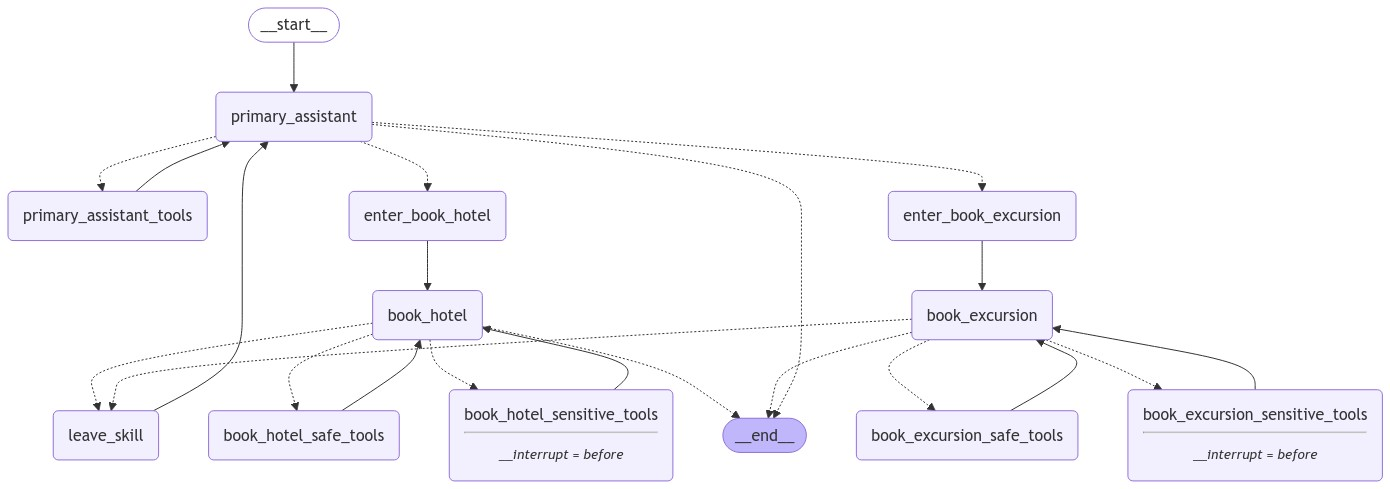

In [19]:
from IPython.display import Image, display

try:
    display(Image(part_4_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Conversation

In [20]:
import shutil
import uuid

# Update with the backup file so we can restart from the original place in each section
thread_id = str(uuid.uuid4())

tutorial_questions = [
    "Hola, necesito un hotel en Santiago para 1 noche a partir del 4 de noviembre de este año 2024, para mi esposa, mi hijo de 3 años y yo.",
    "Olvidalo. Necesito que ahora me busques un servicio de transfer que me vaya a buscar al aeropueto y me lleve al hotel en Santiago, en la misma fecha antes indicada, solo para mí"
    # "Hi there, i need a hotel in Torres del Paine for 1 night starting on October 4th, for me and my wife and my 3 years old son.",
    # "Olá, preciso de um hotel em Torres del Paine por 1 noite a partir de 4 de outubro, para mim, minha esposa e meu filho de 3 anos.",
    # "Bonjour, j'ai besoin d'un hôtel à Torres del Paine pour 1 nuit à partir du 4 octobre, pour moi, ma femme et mon fils de 3 ans",
    # "Am i allowed to update my flight to something sooner? I want to leave later today.",
    # "Update my flight to sometime next week then",
    # "The next available option is great",
    # "what about lodging and transportation?",
    # "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
    # "OK could you place a reservation for your recommended hotel? It sounds nice.",
    # "yes go ahead and book anything that's moderate expense and has availability.",
    # "Now for a car, what are my options?",
    # "Awesome let's just get the cheapest option. Go ahead and book for 7 days",
    # "Cool so now what recommendations do you have on excursions?",
    # "Are they available while I'm there?",
    # "interesting - i like the museums, what options are there? ",
    # "OK great pick one and book it for my second day there.",
]

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
for question in tutorial_questions:
    events = part_4_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = part_4_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        user_input = input(
            "Do you approve of the above actions? Type 'y' to continue;"
            " otherwise, explain your requested changed.\n\n"
        )
        if user_input.strip() == "y":
            # Just continue
            result = part_4_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = part_4_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = part_4_graph.get_state(config)

================================ Human Message =================================

Hola, necesito un hotel en Santiago para 1 noche a partir del 4 de noviembre de este año 2024, para mi esposa, mi hijo de 3 años y yo.
================================== Ai Message ==================================
Tool Calls:
  ToHotelBookingAssistant (call_RKdFSHs9nALNXPVZhCvI26Qu)
 Call ID: call_RKdFSHs9nALNXPVZhCvI26Qu
  Args:
    location: Santiago
    checkin_date: 2024-11-04
    checkout_date: 2024-11-05
    request: para mi esposa, mi hijo de 3 años y yo
Currently in:  book_hotel
================================= Tool Message =================================

The assistant is now the Hotel Booking Assistant. Reflect on the above conversation between the host assistant and the user. The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are Hotel Booking Assistant, and the booking, update, other other action is not complete until after you have successfully inv

In [21]:
# result = part_4_graph.invoke({"messages": ("user", input("Quiero reservar el hotel"))}, config)
# print(result)